<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### 
Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [2]:
import zipfile

zip_path = r'C:\HW3_DL\cable-20250408T103657Z-001.zip'
extract_dir = r'C:\HW3_DL\HW3'  # 解壓後放這裡

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ 解壓縮完成！")



✅ 解壓縮完成！


In [3]:
file_paths_test = glob.glob(r'C:\HW3_DL\HW3\cable\test\*\*.png')
file_paths_test = sorted(file_paths_test)
print(f"共找到 {len(file_paths_test)} 張圖片")

共找到 150 張圖片


In [4]:
all_data = []

for img in tqdm(file_paths_test):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)
    
all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/150 [00:00<?, ?it/s]

(150, 1024, 1024, 3)


Classes: ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'good', 'missing_cable', 'missing_wire', 'poke_insulation']


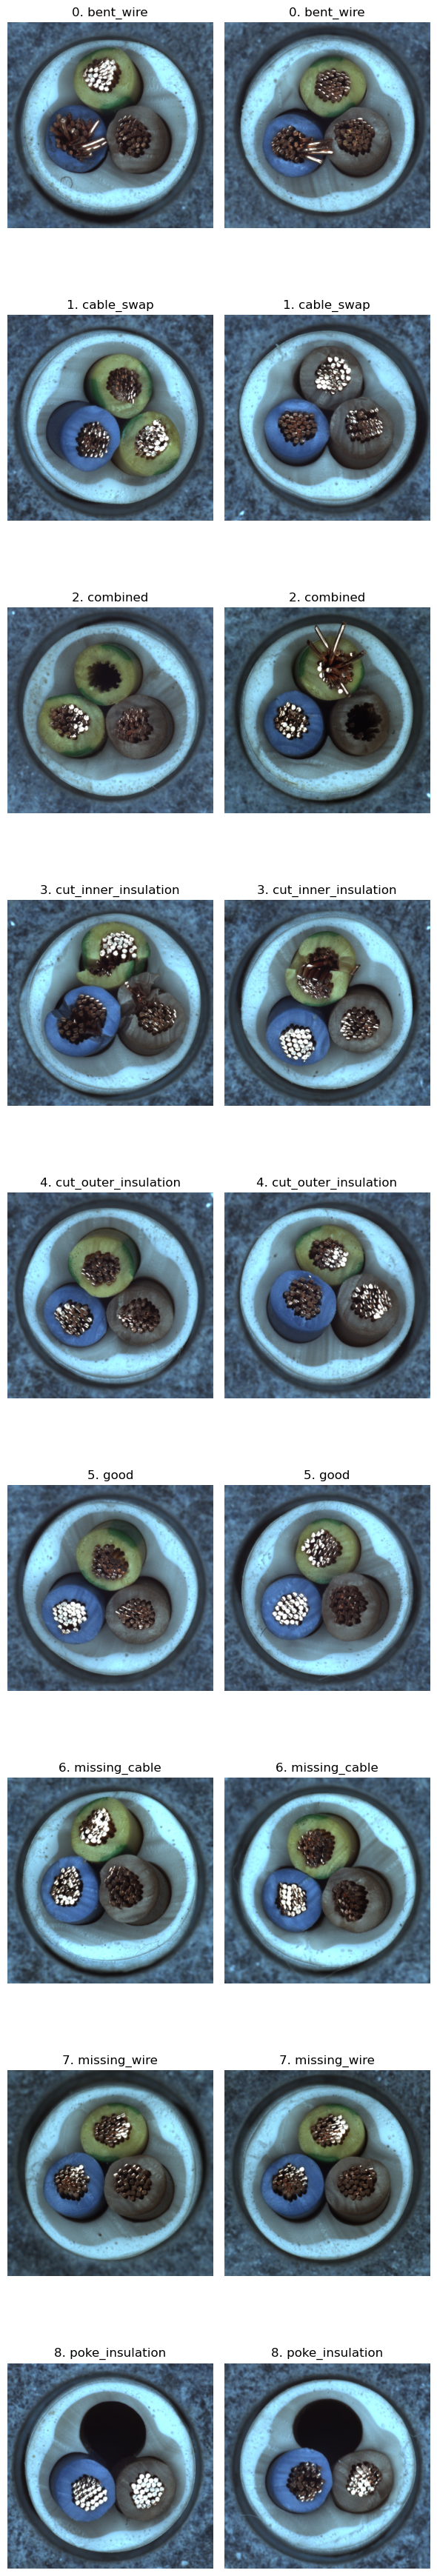

In [5]:
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(set([path.split('\\')[-2] for path in file_paths_test]))
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [6]:
file_paths_train = glob.glob(r'C:\HW3_DL\HW3\cable\train\*\*.png')
file_paths_train = sorted(file_paths_train)
print(f"共找到 {len(file_paths_train)} 張圖片")
num_total_images = len(file_paths_train) + len(file_paths_test)

train_count = len(file_paths_train)
test_count = len(file_paths_test)

defect_classes = sorted(set([
    path.split('\\')[-2]
    for path in file_paths_test
    if 'good' not in path
]))

from PIL import Image
img = Image.open(file_paths_train[0])
print(img.size)

共找到 224 張圖片
(1024, 1024)


In [7]:
print("Dataset Summary for 'cable':")
print(f"• Number of defect classes: {len(defect_classes)}")
print(f"• Types of defect classes: {defect_classes}")
print(f"• Total number of images: {num_total_images}")
print(f"• Distribution: {train_count} training / {test_count} test")
print(f"• Image dimensions: {img.size[0]} x {img.size[1]} pixels")

Dataset Summary for 'cable':
• Number of defect classes: 8
• Types of defect classes: ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation']
• Total number of images: 374
• Distribution: 224 training / 150 test
• Image dimensions: 1024 x 1024 pixels


## A. Data Loading and Preprocessing

In [8]:
import torch
print("CUDA 可用？", torch.cuda.is_available())
print("使用的 GPU：", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "無")
print("torch 版本：", torch.__version__)
print("編譯支援 CUDA？", torch.version.cuda)

CUDA 可用？ True
使用的 GPU： NVIDIA GeForce RTX 3070
torch 版本： 2.5.1
編譯支援 CUDA？ 12.1


In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = 8
images_per_class = 10
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (64, 3, 1024, 1024)
Shape of x_val: (16, 3, 1024, 1024)
Shape of y_train: (64,)
Shape of y_val: (16,)


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),                     # 旋轉 ±10 度
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 顏色亮度對比調整
        transforms.ToTensor()
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [11]:
batch_size = 16

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)#, persistent_workers=True)

## B. Defining Neural Networks

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 8

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## C. Training the Neural Network

In [13]:
import torch
print(torch.cuda.is_available())  # False 就代表你用的是 CPU-only 版本

True


In [14]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([16, 3, 128, 128]) torch.Size([16])


In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
from torch.optim import SGD

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=5e-4)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 2.3909, Train acc: 9.3750%, Val loss: 2.0822, Val acc: 12.5000%, Best Val loss: 2.0822 Best Val acc: 12.50%
Epoch 2/50, Train loss: 2.1378, Train acc: 17.1875%, Val loss: 2.0874, Val acc: 12.5000%, Best Val loss: 2.0822 Best Val acc: 12.50%
Epoch 3/50, Train loss: 1.9122, Train acc: 29.6875%, Val loss: 2.1248, Val acc: 12.5000%, Best Val loss: 2.0822 Best Val acc: 12.50%
Epoch 4/50, Train loss: 1.8841, Train acc: 37.5000%, Val loss: 2.1529, Val acc: 12.5000%, Best Val loss: 2.0822 Best Val acc: 12.50%
Epoch 5/50, Train loss: 1.6081, Train acc: 42.1875%, Val loss: 2.1391, Val acc: 12.5000%, Best Val loss: 2.0822 Best Val acc: 12.50%
Epoch 6/50, Train loss: 1.4184, Train acc: 51.5625%, Val loss: 2.1452, Val acc: 12.5000%, Best Val loss: 2.0822 Best Val acc: 12.50%
Epoch 7/50, Train loss: 1.3327, Train acc: 51.5625%, Val loss: 2.1784, Val acc: 25.0000%, Best Val loss: 2.0822 Best Val acc: 25.00%
Epoch 8/50, Train loss: 1.1785, Train acc: 59.3750%, Val loss: 2.2078,

### Visualizing model performance

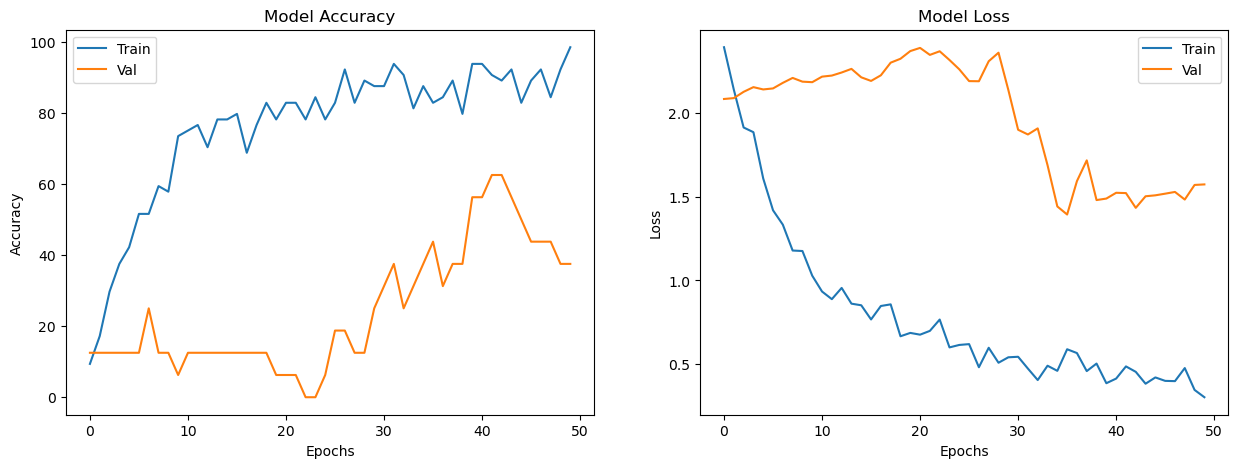

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [17]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

C:\Users\a0983\AppData\Local\Temp\ipykernel_15184\2359298804.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_classification.pth')

tensor([7, 0, 1, 7, 3, 2, 3, 3, 4, 0, 5, 5, 4, 7, 7, 7], device='cuda:0')
tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7], device='cuda:0')
Test accuracy is 62.5%
